# Pokemon Image Classifier

Image classifier built using TensorFlow

## Usage

To identify what species of Pokemon a given image resembles. Could be used to see which Pokemon one's pet or drawing most closely resembles

## Data

I combined two datasets from Kaggle and modified the datasets such that there includes an image repository and a csv file of pokemon names and their corresponding image file names.

The data sets used:
* https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types
* https://www.kaggle.com/datasets/lantian773030/pokemonclassification

## Imports and setup

In [66]:
import tensorflow as tf
import tensorflow_hub as hub 
print(tf.__version__)

2.12.0


In [67]:
# check GPU (Google Colab)
print("GPU available") if tf.config.list_physical_devices("GPU") else "GPU not available"

GPU available


In [68]:
# grab data
import pandas as pd
import numpy as np
csv_labels = pd.read_csv("drive/MyDrive/PokePet/data/test_scrubbed.csv")
print(csv_labels.describe())
print()
print(csv_labels.head())

           name                                      file
count     14000                                     14000
unique      997                                     14000
top     pikachu  60fac3cc-dba0-4d1b-9839-5ca232fe1175.png
freq        181                                         1

      name                                      file
0   mankey  60fac3cc-dba0-4d1b-9839-5ca232fe1175.png
1   spheal  6b8970db-d76e-4439-b9af-96bde91372e4.png
2  beartic  44f2aa0f-b041-4b1c-b96f-9af5b9a72768.png
3   seadra  8bd08ff4-dbbc-4722-9c18-96b0e1583375.png
4   oddish  56b1ed32-a9b1-40a5-a5fc-4c34f19a27a1.png


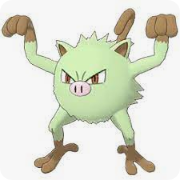

In [69]:
# test view of an image
from IPython.display import Image
Image("drive/MyDrive/PokePet/data/test-images/60fac3cc-dba0-4d1b-9839-5ca232fe1175.png")

In [70]:
# make pathname from image labels
pokepics = ["drive/MyDrive/PokePet/data/test-images/" + f for f in csv_labels["file"]]
pokepics[:5]

['drive/MyDrive/PokePet/data/test-images/60fac3cc-dba0-4d1b-9839-5ca232fe1175.png',
 'drive/MyDrive/PokePet/data/test-images/6b8970db-d76e-4439-b9af-96bde91372e4.png',
 'drive/MyDrive/PokePet/data/test-images/44f2aa0f-b041-4b1c-b96f-9af5b9a72768.png',
 'drive/MyDrive/PokePet/data/test-images/8bd08ff4-dbbc-4722-9c18-96b0e1583375.png',
 'drive/MyDrive/PokePet/data/test-images/56b1ed32-a9b1-40a5-a5fc-4c34f19a27a1.png']

In [71]:
# prepare labels
pokemons = csv_labels["name"].to_numpy()
pokemons

array(['mankey', 'spheal', 'beartic', ..., 'pikachu', 'graveler',
       'yungoos'], dtype=object)

In [72]:
# find unique pokemon
unique_pokemons = np.unique(pokemons)

In [73]:
# turn every label into array of bools
bool_pokemons = [ pokemon == unique_pokemons for pokemon in pokemons]
len(bool_pokemons)

14000

In [74]:
# create sets
X = pokepics
y = bool_pokemons

In [75]:
# set slider for num of pictures to experiment with (save time)
NUM_IMAGES = 5000 #@param {type:"slider", min:1500, max:10000, step: 500}

In [76]:
# split data into train and validation
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=22)

len(X_train), len(y_train), len(X_val), len(y_val)

(4000, 4000, 1000, 1000)

## Turn images into Tensors (numeric representation

In [77]:
IMG_SIZE = 224

# func to turn img into Tensor
def process_img(img_path, img_size=IMG_SIZE):
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [78]:
# func to get tuple
def get_image_label(image_path, label):
  image = process_img(image_path)
  return image, label

In [79]:
# func to turn data into batches
def create_batches(X, y=None, batch_size=32, valid_data=False, test_data=False):
  if test_data:
    print("Creating test data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) 
    data_batch = data.map(process_img).batch(32)
    return data_batch
  
  elif valid_data:
    print("Creating validation data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), 
                                               tf.constant(y))) 
    data_batch = data.map(get_image_label).batch(32)
    return data_batch

  else:
    print("Creating training data batches")
    # turn into numeric tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # shuffle
    data = data.shuffle(buffer_size=len(X))

    # get label
    data = data.map(get_image_label)

    # turn training data into batches
    data_batch = data.batch(32)
  return data_batch

In [80]:
# create the batches
train_batches = create_batches(X_train, y_train)
val_batches = create_batches(X_val, y_val, valid_data=True)

Creating training data batches
Creating validation data batches


In [81]:
train_batches.element_spec, val_batches.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 997), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 997), dtype=tf.bool, name=None)))

In [82]:
# input and output shapes for model
INPUT_SHAPE = [None, 224, 224, 3]
OUTPUT_SHAPE = len(unique_pokemons)

In [83]:
# model from TensorFlow Hub
# classification model
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [84]:
# func to build Keras model
def build_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):

  # Setup model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build model
  model.build(INPUT_SHAPE)

  return model

In [85]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_3 (Dense)             (None, 997)               998994    
                                                                 
Total params: 6,431,707
Trainable params: 998,994
Non-trainable params: 5,432,713
_________________________________________________________________


In [86]:
# create tensorboard callback
%load_ext tensorboard
import os
import datetime

def create_tb_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/PokePet/data/logs",
                        # track logs
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [87]:
# early stop callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

In [88]:
# train model
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [89]:
# func to train and return model
def train_model():
  model = build_model()
  tb = create_tb_callback()

  
  model.fit(x=train_batches,
            epochs=NUM_EPOCHS,
            validation_data=val_batches,
            validation_freq=1,
            callbacks=[tb, early_stop])

  return model

In [90]:
model = train_model()

Epoch 1/100
125/125 [==============================] - 374s 3s/step - loss: 7.6796 - accuracy: 0.0262 - val_loss: 6.8485 - val_accuracy: 0.0470
Epoch 2/100
125/125 [==============================] - 18s 143ms/step - loss: 3.3977 - accuracy: 0.3523 - val_loss: 6.8599 - val_accuracy: 0.0730
Epoch 3/100
125/125 [==============================] - 19s 149ms/step - loss: 1.5085 - accuracy: 0.7425 - val_loss: 6.9257 - val_accuracy: 0.0840
Epoch 4/100
125/125 [==============================] - 18s 148ms/step - loss: 0.7806 - accuracy: 0.8840 - val_loss: 7.0606 - val_accuracy: 0.0890
Epoch 5/100
125/125 [==============================] - 18s 146ms/step - loss: 0.4377 - accuracy: 0.9477 - val_loss: 7.1617 - val_accuracy: 0.0920
Epoch 6/100
125/125 [==============================] - 20s 160ms/step - loss: 0.2614 - accuracy: 0.9793 - val_loss: 7.2268 - val_accuracy: 0.0910
Epoch 7/100
125/125 [==============================] - 18s 145ms/step - loss: 0.1736 - accuracy: 0.9893 - val_loss: 7.2596 - v

In [94]:
# save model
def save_model(model, suffix=None):
  modeldir = os.path.join("drive/MyDrive/PokePet/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5"
  model.save(model_path)
  return model_path

# load model
def load_model(model_path):
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [97]:
# make full data model
full_data = create_batches(X,y)

full_model = build_model()

Creating training data batches


In [98]:
# full model callback
full_model_tb = create_tb_callback()
full_model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [99]:
# fit full model
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tb, full_model_early_stop])

Epoch 1/100
438/438 [==============================] - 900s 2s/step - loss: 6.5726 - accuracy: 0.0722
Epoch 2/100
438/438 [==============================] - 46s 104ms/step - loss: 3.3282 - accuracy: 0.3597
Epoch 3/100
438/438 [==============================] - 45s 102ms/step - loss: 2.0473 - accuracy: 0.5799
Epoch 4/100
438/438 [==============================] - 46s 106ms/step - loss: 1.3621 - accuracy: 0.7145
Epoch 5/100
438/438 [==============================] - 45s 103ms/step - loss: 0.9555 - accuracy: 0.8010
Epoch 6/100
438/438 [==============================] - 46s 106ms/step - loss: 0.6916 - accuracy: 0.8651
Epoch 7/100
438/438 [==============================] - 46s 105ms/step - loss: 0.5235 - accuracy: 0.9009
Epoch 8/100
438/438 [==============================] - 45s 103ms/step - loss: 0.4026 - accuracy: 0.9290
Epoch 9/100
438/438 [==============================] - 45s 103ms/step - loss: 0.3189 - accuracy: 0.9468
Epoch 10/100
438/438 [==============================] - 47s 107ms/

In [100]:
# save model to file
save_model(full_model, suffix="test-images-Adam-opt")

'drive/MyDrive/PokePet/models/20230430-21351682890537-test-images-Adam-opt.h5'

In [102]:
# load model
loaded_model = load_model('drive/MyDrive/PokePet/models/20230430-21351682890537-test-images-Adam-opt.h5')

## Make predictions with test data

In [107]:
# predicition funcs
import matplotlib.pyplot as plt

# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  return unique_pokemons[np.argmax(prediction_probabilities)]

def plot_preds(prediction_probabilities, labels, images, n=1):

  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  pred_label = get_pred_label(pred_prob)
  
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

In [109]:
test_path = "drive/MyDrive/PokePet/data/finaltest-images/"
test_files = [ test_path + filename for filename in os.listdir(test_path)]

test_files_shortened = test_files[:20]
test_files_shortened

['drive/MyDrive/PokePet/data/finaltest-images/comfey.jpg',
 'drive/MyDrive/PokePet/data/finaltest-images/articuno.png',
 'drive/MyDrive/PokePet/data/finaltest-images/bulbasaur.png',
 'drive/MyDrive/PokePet/data/finaltest-images/dedenne.png',
 'drive/MyDrive/PokePet/data/finaltest-images/banette.png',
 'drive/MyDrive/PokePet/data/finaltest-images/alakazam.png',
 'drive/MyDrive/PokePet/data/finaltest-images/charizard.png',
 'drive/MyDrive/PokePet/data/finaltest-images/yanmega.png',
 'drive/MyDrive/PokePet/data/finaltest-images/zigzagoon.png',
 'drive/MyDrive/PokePet/data/finaltest-images/lumineon.png',
 'drive/MyDrive/PokePet/data/finaltest-images/pidove.png',
 'drive/MyDrive/PokePet/data/finaltest-images/sandshrew.png',
 'drive/MyDrive/PokePet/data/finaltest-images/pyroar.png',
 'drive/MyDrive/PokePet/data/finaltest-images/yveltal.png',
 'drive/MyDrive/PokePet/data/finaltest-images/magmortar.png',
 'drive/MyDrive/PokePet/data/finaltest-images/parasect.png',
 'drive/MyDrive/PokePet/data/

In [110]:
# Create test data batch and predict
test_data = create_batches(test_files_shortened, test_data=True)
test_preds = loaded_model.predict(test_data)

# Get test image prediction labels
test_pred_labels = [get_pred_label(test_preds[i]) for i in range(len(test_preds))]
test_pred_labels

Creating test data batches
1/1 [==============================] - 1s 950ms/step


['audino',
 'articuno',
 'illumise',
 'audino',
 'iron',
 'alakazam',
 'charizard',
 'basculin',
 'cosmog',
 'eternatus',
 'iron',
 'steelix',
 'diancie',
 'yveltal',
 'magmortar',
 'regieleki',
 'slowbro',
 'skeledirge',
 'nincada',
 'hoopa']

In [111]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
test_images = []

# Loop through unbatched data
for image in test_data.unbatch().as_numpy_iterator():
  test_images.append(image)

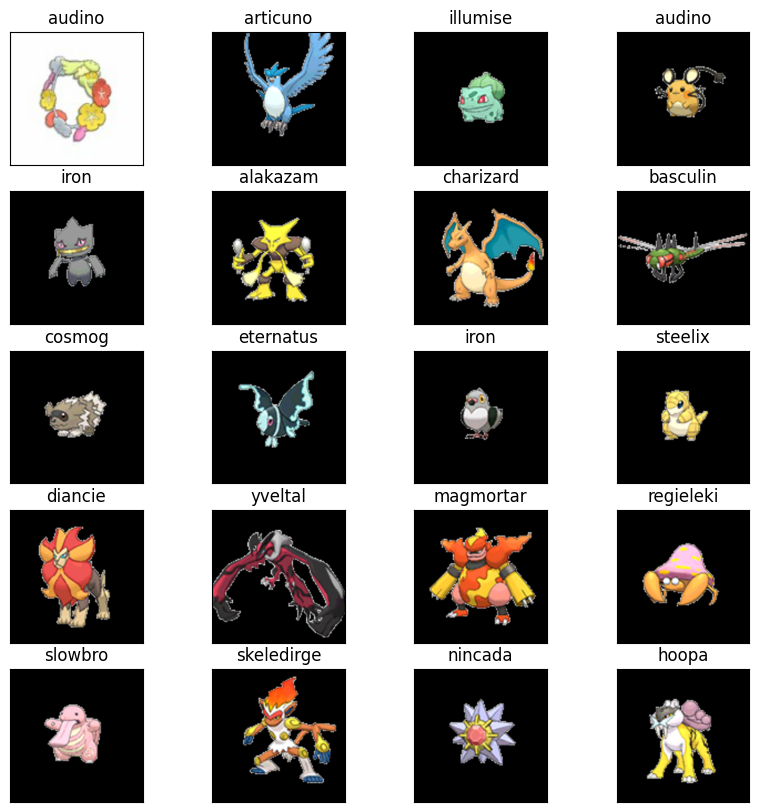

In [114]:
plt.figure(figsize=(10, 10))
for i, image in enumerate(test_images):
    plt.subplot(5, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(test_pred_labels[i])
    plt.imshow(image)

### Needs improvement! 
* Pokemon labels need cleaning
* Images need auditing